# ACS2 in Maze
This notebook presents how to integrate ACS2 algorithm with maze environment (using OpenAI Gym interface).

Begin with attaching required dependencies. Because most of the work is by now done locally no PIP modules are used (just pure OS paths)

In [2]:
%matplotlib inline

# General
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Logger
import logging
logging.basicConfig(level=logging.INFO)

# ALCS + Maze environment
import sys
sys.path.append('/Users/khozzy/Projects/pyalcs')
sys.path.append("/Users/khozzy/Projects/openai-maze-envs")

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from alcs import ACS2, ACS2Configuration

# Load environments
import gym
import gym_maze

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment - Maze
We are going to look at provided mazes. Their names starts with "_Maze..._" so see what is possible to load:

In [3]:
all_envs = [env for env in gym.envs.registry.all()]
maze_envs = [env for env in all_envs if env.id.startswith("Maze")]

for env in maze_envs:
    print("Maze ID: [{}], non-deterministic: [{}], trials: [{}]".format(
            env.id, env.nondeterministic, env.trials))

Maze ID: [MazeF1-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF2-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF3-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF4-v0], non-deterministic: [True], trials: [100]
Maze ID: [Maze5-v0], non-deterministic: [True], trials: [100]


Let's see how it looks in action. First we are going to initialize new environment using `gym.make()` instruction from OpenAI Gym.

In [4]:
MAZE = "MazeF3-v0"

# Initialize environment
maze = gym.make(MAZE)

# Reset it, by putting an agent into random position
situation = maze.reset()

# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■
■ □ □ A $ ■
■ □ ■ ■ ■ ■
■ □ □ □ ■ ■
■ □ ■ ■ ■ ■
■ ■ ■ ■ ■ ■


The `reset()` function puts an agent into random position (on path inside maze) returning current perception.

> The perception consists of 8 values representing N, NE, E, SE, S, SW, W, NW directions. It outputs 0 for the path, 1 for the wall and 9 for the reward.

In [5]:
# Show current agents perception
situation

('1', '1', '9', '1', '1', '1', '0', '1')

We can interact with the environment by performing actions.

> Agent can perform 8 actions - moving into different directions.

To do so use `step(action)` function. It will return couple interesting information:
- new state percepton,
- reward for executing move (ie. finding the reward)
- is the trial finish,
- debug data

In [6]:
ACTION = 0 # Move N

# Execute action
state, reward, done, _ = maze.step(ACTION)

# Show new state
print("New state: {}, reward: {}, is done: {}".format(state, reward, done))

# Render the env one more time after executing step
maze.render()

New state: ('1', '1', '9', '1', '1', '1', '0', '1'), reward: 0, is done: False

■ ■ ■ ■ ■ ■
■ □ □ A $ ■
■ □ ■ ■ ■ ■
■ □ □ □ ■ ■
■ □ ■ ■ ■ ■
■ ■ ■ ■ ■ ■


## Agent - ACS2
First provide a helper method for calculating obtained knowledge

In [7]:
def calculate_knowledge(maze, population):
    transitions = maze.env.get_all_possible_transitions()

    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0

    # For all possible destinations from each path cell
    for start, action, end in transitions:
        p0 = maze.env.maze.perception(*start)
        p1 = maze.env.maze.perception(*end)

        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions) * 100.0

### Exploration phase

In [11]:
# Create the empty agent with default configuration
cfg = ACS2Configuration.default()
agent = ACS2(cfg)

# Trials to run the agent
TRIALS = 10

# Exploration phase
maze.reset()
population, metrics = agent.explore(maze, TRIALS)

# Calculate obtained knowledge
knowledge = calculate_knowledge(maze, population)

print(cfg)
print("Knowledge learned after executing {} trials: {:.2f}%".format(TRIALS, knowledge))

ACS2Configuration:
	- Classifier length: [8]
	- Number of possible actions: [8]
	- Classifier wildcard: [#]
	- Do GA: [False]
	- Do subsumption: [True]
	- Beta: [0.05]
	- ...
Knowledge learned after executing 10 trials: 0.00%


We can take a sneak peek into a created list of classifiers. Let's have a look at top 10:

In [12]:
population.sort(key=lambda cl: -cl.fitness)

for cl in population[:10]:
    print("{!r} \tq: {:.2f} \tr: {:.2f} \tir: {:.2f}".format(cl, cl.q, cl.r, cl.ir))

##9#####-2-##1##### @ 0x1143bec50 	q: 0.73 	r: 302.01 	ir: 301.66
##0##0#0-2-##1##1#1 @ 0x114391c18 	q: 0.74 	r: 56.49 	ir: 53.10
##0##0#1-2-##9##1## @ 0x11439e630 	q: 0.75 	r: 47.13 	ir: 0.00
##1#####-2-######## @ 0x1143917b8 	q: 0.88 	r: 36.90 	ir: 33.47
#0######-2-######## @ 0x11438d550 	q: 0.73 	r: 33.23 	ir: 31.51
##0##0##-2-##9##1## @ 0x1143beba8 	q: 0.55 	r: 43.05 	ir: 0.00
00######-2-######## @ 0x1143917f0 	q: 0.67 	r: 31.69 	ir: 29.94
0#1#####-2-######## @ 0x114391e10 	q: 0.59 	r: 31.69 	ir: 29.94
0##0####-2-######## @ 0x11440e588 	q: 0.50 	r: 32.11 	ir: 27.02
######0#-0-######## @ 0x1143d07f0 	q: 0.82 	r: 17.68 	ir: 0.00


### Exploitation

Now we can either reuse our previous agent or initialize it one more time passing the initial population of classifiers as *apriori* knowledge.

In [13]:
# Reinitialize agent
agent = ACS2(cfg, population)

# Reset the environment
maze.reset()
population, metrics = agent.exploit(maze, TRIALS)

In [14]:
metrics[0:3]

[{'fitness': 9.424608873255407,
  'numerosity': 70,
  'population': 70,
  'reliable': 0,
  'steps': 50,
  'total_steps': 50,
  'trial': 0},
 {'fitness': 9.291755595084208,
  'numerosity': 70,
  'population': 70,
  'reliable': 0,
  'steps': 50,
  'total_steps': 100,
  'trial': 1},
 {'fitness': 9.839377473091979,
  'numerosity': 70,
  'population': 70,
  'reliable': 0,
  'steps': 3,
  'total_steps': 103,
  'trial': 2}]

Let's write a helper function for performing multiple experiments and averaging the results. 

In [15]:
def explore(cfg, maze, experiments, trials):
    all_metrics = []
    
    for experiment_id in range(0, experiments):
        # Create agent for each experiment independently
        agent = ACS2(cfg)
        
        for trial_id in range(0, trials):
            # Execute function
            population, metrics = agent.explore(maze)

            # Calculate obtained knowledge
            knowledge = calculate_knowledge(maze, population)

            # Append extra metrics
            metrics[0]['experiment_id'] = experiment_id
            metrics[0]['trial_id'] = trial_id
            metrics[0]['knowledge'] = knowledge
        
            all_metrics.append(metrics[0])
    
    # Return last trained agent and all metrics
    return agent, all_metrics

# Here we are going to reuse the same agent
def exploit(agent, maze, experiments, trials):
    all_metrics = []
    
    for experiment_id in range(0, experiments):        
        for trial_id in range(0, trials):
            # Execute function
            population, metrics = agent.exploit(maze)

            # Calculate obtained knowledge
            knowledge = calculate_knowledge(maze, population)

            # Append extra metrics
            metrics[0]['experiment_id'] = experiment_id
            metrics[0]['trial_id'] = trial_id
            metrics[0]['knowledge'] = knowledge
        
            all_metrics.append(metrics[0])
    
    # Return last trained agent and all metrics
    return all_metrics

def experiment(agent, cfg, maze, experiments, explore_trials, exploit_trials):
    from copy import copy
    
    # Run the exploration phase
    last_agent, explore_metrics = explore(cfg, maze, experiments, explore_trials)
    
    # Run the exploitation phase
    exploit_metrics = exploit(copy(last_agent), maze, experiments, exploit_trials)
    
    return last_agent, explore_metrics, exploit_metrics

In [16]:
def to_df(metrics):
    # Convert to Pandas DataFrame
    metrics_df = pd.DataFrame(metrics).groupby(['trial_id']).mean()
    metrics_df.drop(['experiment_id', 'trial'], inplace=True, axis=1)
    
    return metrics_df

def convert(explore_metrics, exploit_metric):
    explore_df = to_df(explore_metrics)
    exploit_df = to_df(exploit_metrics)
    
    # Reindex dataframes
    explore_df.index = range(1, len(explore_df.index)+1)
    switch = explore_df.index[-1]
    exploit_df.index = range(switch, switch + len(exploit_df.index))
    
    return explore_df, exploit_df

In [17]:
cfg = ACS2Configuration.default()
agent = ACS2(cfg)
maze = gym.make('Maze5-v0')

EXPERIMENTS = 2
TRIALS_EXPLORE = 400
TRIALS_EXPLOIT = 50

# Run the experiments
last_agent, explore_metrics, exploit_metrics = experiment(agent, cfg, maze,
                                              EXPERIMENTS, TRIALS_EXPLORE, TRIALS_EXPLOIT)

# Convert metrics into DataFrames
explore_df, exploit_df = convert(explore_metrics, exploit_metrics)

TypeError: explore() missing 1 required positional argument: 'max_trials'

In [14]:
# Show 5 random averaged metrics
explore_df.sample(5).sort_index()

,fitness,knowledge,numerosity,population,reliable,steps
21,4.426318,1.369863,404.0,404.0,13.5,50.0
66,8.042977,18.835616,474.5,474.5,61.5,50.0
71,8.583216,20.890411,473.0,473.0,65.0,50.0
85,9.958272,30.136986,471.0,471.0,84.0,50.0
209,38.449713,86.643836,393.5,393.5,277.0,50.0


In [15]:
# Show 5 random averaged metrics
exploit_df.sample(5).sort_index()

,fitness,knowledge,numerosity,population,reliable,steps
410,120.982065,99.315068,383.0,383.0,381.0,4.5
421,122.653234,99.315068,383.0,383.0,381.0,6.0
423,122.867583,99.315068,383.0,383.0,381.0,3.5
433,124.242264,99.315068,383.0,383.0,381.0,6.5
435,124.511075,99.315068,383.0,383.0,381.0,6.0


## Experiments
For various mazes visualize
- classifiers / reliable classifiers for steps
- optimal policy
- steps (exploration | exploitation)
- knowledge
- parameters setting

In [16]:
from alcs.acs2 import ClassifiersList

def find_best_classifier(population, situation):
    match_set = ClassifiersList.form_match_set(population, situation)
    anticipated_change_cls = [cl for cl in match_set if cl.does_anticipate_change()]
    
    if (len(anticipated_change_cls) > 0):
        return max(anticipated_change_cls, key=lambda cl: cl.fitness)
    
    return None

def build_fitness_matrix(env, population):
    original = maze.env.maze.matrix
    fitness = original.copy()
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception)
            if best_cl:
                fitness[index] = best_cl.fitness
            else:
                fitness[index] = -1
        
        # Wall - fitness = 0
        if x == 1:
            fitness[index] = 0
        
        # Reward - inf fitness
        if x == 9:
            fitness[index] = fitness.max () + 500
        
    return fitness
    
def build_action_matrix(env, population):
    ACTION_LOOKUP = { 
        0: '↑', 1: '↗', 2: '→', 3: '↘',
        4: '↓', 5: '↙', 6: '←', 7: '↖'
    }
    
    original = maze.env.maze.matrix
    action = original.copy().astype(str)
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception)
            if best_cl:
                action[index] = ACTION_LOOKUP[best_cl.action]
            else:
                action[index] = '?'
        
        # Wall - fitness = 0
        if x == 1:
            action[index] = '\#'
        
        # Reward - inf fitness
        if x == 9:
            action[index] = 'R'
        
    return action

print(build_action_matrix(maze, last_agent.population))

[['\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#']
 ['\\#' '→' '→' '→' '→' '→' '→' 'R' '\\#']
 ['\\#' '↑' '↘' '\\#' '↗' '\\#' '\\#' '↑' '\\#']
 ['\\#' '↗' '\\#' '↗' '→' '→' '↗' '↑' '\\#']
 ['\\#' '→' '↗' '↑' '\\#' '\\#' '↑' '↑' '\\#']
 ['\\#' '↗' '\\#' '↑' '\\#' '↗' '↗' '\\#' '\\#']
 ['\\#' '↑' '\\#' '→' '↗' '\\#' '↑' '↖' '\\#']
 ['\\#' '↑' '→' '↗' '↑' '↖' '\\#' '↑' '\\#']
 ['\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#']]


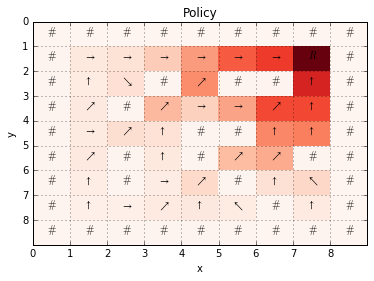

In [17]:
def plot_policy(env,agent, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_aspect("equal")
    
    # Handy variables
    maze_countours = maze.env.maze.matrix
    max_x = maze.env.maze.max_x
    max_y = maze.env.maze.max_y
    
    fitness_matrix = build_fitness_matrix(maze, agent.population)
    action_matrix = build_action_matrix(maze, agent.population)
    
    # Render maze as image
    plt.imshow(fitness_matrix, interpolation='none', cmap='Reds', aspect='auto',
           extent=[0, max_x, max_y, 0])
    
    # Add labels to each cell
    for (y,x), val in np.ndenumerate(action_matrix):
        plt.text(x+0.4, y+0.5, "${}$".format(val))
    
    ax.set_title("Policy")
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax.set_xlim(0, max_x)
    ax.set_ylim(max_y, 0)
    
    ax.set_xticks(range(0, max_x))
    ax.set_yticks(range(0, max_y))
    
    ax.grid(True)

plot_policy(maze, last_agent)

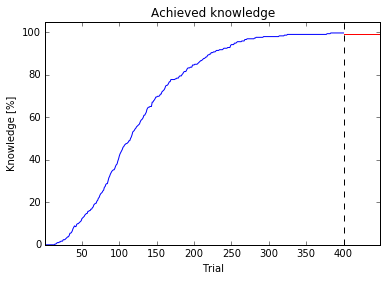

In [18]:
def plot_knowledge(explore_df, exploit_df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df['knowledge'].plot(ax=ax, c='blue')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
        
    ax.set_title("Achieved knowledge")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Knowledge [%]")
    ax.set_ylim([0, 105])

plot_knowledge(explore_df, exploit_df)

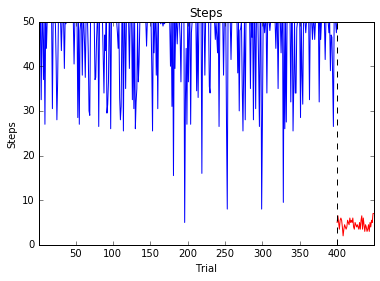

In [19]:
def plot_steps(explore_df, exploit_df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df['steps'].plot(ax=ax, c='blue')
    exploit_df['steps'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Steps")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Steps")
    
plot_steps(explore_df, exploit_df)

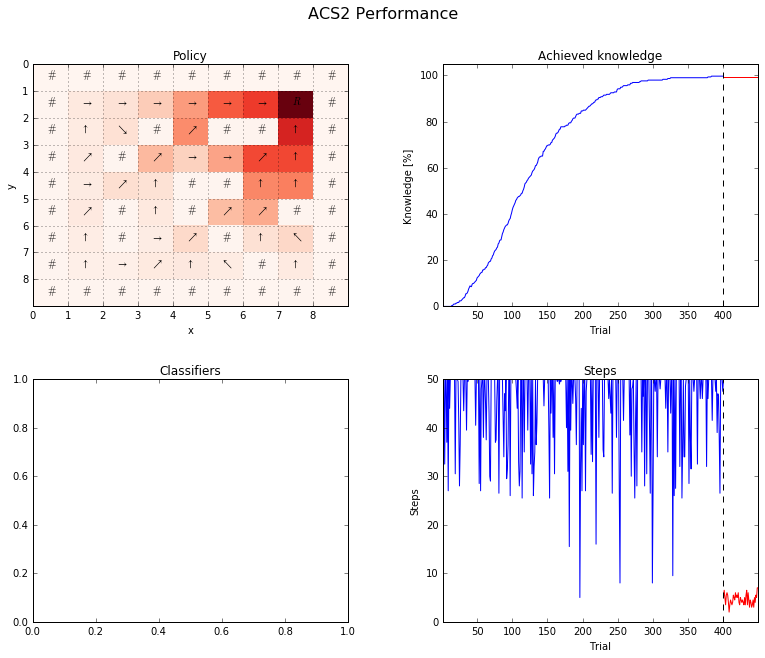

In [20]:
def plot_performance(agent, maze, explore_df, exploit_df):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle('ACS2 Performance', fontsize=16)
    
    ax1 = plt.subplot(221)
    plot_policy(maze, agent, ax1)
    
    ax2 = plt.subplot(222)
    plot_knowledge(explore_df, exploit_df, ax2)
    
    ax3 = plt.subplot(223)
    ax3.set_title("Classifiers")
    
    ax4 = plt.subplot(224)
    plot_steps(explore_df, exploit_df, ax4)
    
    plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.3)
    plt.show()

plot_performance(last_agent, maze, explore_df, exploit_df)

## Setting different parameters

In [21]:
params = ACS2Parameters(do_ga=True)
agent = ACS2(params=params)
maze = gym.make('MazeF3-v0')

EXPERIMENTS = 5
TRIALS_EXPLORE = 10
TRIALS_EXPLOIT = 5

# Run the experiments
explore_metrics, exploit_metrics = experiment(agent, params, maze,
                                              EXPERIMENTS, TRIALS_EXPLORE, TRIALS_EXPLOIT)

INFO:gym.envs.registration:Making new env: MazeF3-v0
[2017-09-22 05:39:14,022] Making new env: MazeF3-v0


ACS2Parameters: Do GA: [True]
ACS2Parameters: Do GA: [True]
ACS2Parameters: Do GA: [True]
ACS2Parameters: Do GA: [True]
ACS2Parameters: Do GA: [True]
ACS2Parameters: Do GA: [True]


ValueError: too many values to unpack (expected 2)